In [1]:
import os
from fastai.vision import *
import numpy as np
import pandas as pd
import glob
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score

/opt/apps/resif/data/production/v1.2-20191021/default/software/lang/Python/3.7.2-GCCcore-8.2.0/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.10) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
def get_labels(filenames):

    multilabel = [f.split('_')[0:2] for f in filenames]
    slide = [f.split('_')[6] for f in  filenames]

    for idx, sublist in enumerate(multilabel):
        sublist.append(slide[idx])
        if sublist[1] in controls: sublist.insert(0, 'control')
        else: sublist.insert(0, 'mutant')

    multilabel = [' '.join(labels) for labels in multilabel]
    assert len(multilabel) == len(filenames)
    
    return multilabel

In [3]:
PATH = '/work/projects/hcs_ai/abottemanne/thesis/images/RGB_1_5262020/AllImages/data'
runPrefix = 'alexEfficientNetB0FullImgNetOneCycle20_4MULTILABELS'
outputDir = '/work/projects/hcs_ai/abottemanne/thesis/images/RGB_1_5262020/AllImages/output/' + runPrefix
model_type = ('efficientnet-b0', 224) # ('efficientnet-b5', 446) #

print("Output dir: ", outputDir)
try:
    os.makedirs(outputDir)
except Exception:
    pass

controls = ['3C1','68','K7'] #mutants = ['2122','825','826']

all_images = [f for f in os.listdir(PATH) if f.endswith('.png')]
all_images

Output dir:  /work/projects/hcs_ai/abottemanne/thesis/images/RGB_1_5262020/AllImages/output/alexEfficientNetB0FullImgNetOneCycle20_4MULTILABELS


['C3_68_Un_1_4_S_A01_c_4_p_16_RGB_1.png',
 'C2_825_Un_2_13_S_A03_c_4_p_4_RGB_1.png',
 'C2_2122_1000_2_43_S_A03_c_4_p_10_RGB_1.png',
 'C3_825_1000_1_14_S_A01_c_4_p_12_RGB_1.png',
 'C2_826_10_2_41_S_A03_c_4_p_7_RGB_1.png',
 'C2_825_Un_2_17_S_A03_c_4_p_16_RGB_1.png',
 'C2_825_1000_1_19_S_A04_c_4_p_11_RGB_1.png',
 'C1_826_Un_1_9_S_A01_c_4_p_8_RGB_1.png',
 'C2_3C1_1000_1_48_S_A04_c_4_p_9_RGB_1.png',
 'C1_825_100_1_45_S_A04_c_4_p_1_RGB_1.png',
 'C3_825_1000_1_12_S_A01_c_4_p_17_RGB_1.png',
 'C1_826_1000_1_52_S_A03_c_4_p_10_RGB_1.png',
 'C2_3C1_100_1_33_S_A03_c_4_p_8_RGB_1.png',
 'C2_68_10_2_24_S_A02_c_4_p_11_RGB_1.png',
 'C1_3C1_10_1_46_S_A03_c_4_p_1_RGB_1.png',
 'C3_826_10_2_50_S_A03_c_4_p_2_RGB_1.png',
 'C1_825_100_1_4_S_A03_c_4_p_2_RGB_1.png',
 'C2_826_1000_1_61_S_A04_c_4_p_5_RGB_1.png',
 'C3_826_Un_1_31_S_A02_c_4_p_15_RGB_1.png',
 'C1_K7_100_1_5_S_A01_c_4_p_6_RGB_1.png',
 'C1_68_Un_2_16_S_A01_c_4_p_3_RGB_1.png',
 'C2_826_1000_2_49_S_A04_c_4_p_8_RGB_1.png',
 'C2_68_1000_1_43_S_A03_c_4_p_16

In [4]:
multilabel = get_labels(all_images)
multilabel

['control C3 68 A01',
 'mutant C2 825 A03',
 'mutant C2 2122 A03',
 'mutant C3 825 A01',
 'mutant C2 826 A03',
 'mutant C2 825 A03',
 'mutant C2 825 A04',
 'mutant C1 826 A01',
 'control C2 3C1 A04',
 'mutant C1 825 A04',
 'mutant C3 825 A01',
 'mutant C1 826 A03',
 'control C2 3C1 A03',
 'control C2 68 A02',
 'control C1 3C1 A03',
 'mutant C3 826 A03',
 'mutant C1 825 A03',
 'mutant C2 826 A04',
 'mutant C3 826 A02',
 'control C1 K7 A01',
 'control C1 68 A01',
 'mutant C2 826 A04',
 'control C2 68 A03',
 'mutant C1 826 A01',
 'control C3 68 A02',
 'mutant C1 826 A03',
 'control C3 K7 A02',
 'mutant C2 825 A03',
 'control C2 K7 A01',
 'control C2 68 A03',
 'mutant C2 825 A03',
 'control C3 K7 A01',
 'mutant C3 2122 A02',
 'control C3 K7 A01',
 'mutant C2 2122 A04',
 'mutant C1 825 A03',
 'control C2 K7 A01',
 'control C3 K7 A02',
 'control C2 K7 A03',
 'mutant C2 826 A03',
 'control C2 K7 A03',
 'control C1 68 A01',
 'mutant C3 2122 A02',
 'mutant C1 825 A03',
 'control C1 68 A03',
 'c

In [5]:
df_dict = {'image_name' : all_images, 'tags': multilabel}
dframe = pd.DataFrame(df_dict)
dframe.describe()

,image_name,tags
count,7025,7025
unique,7025,60
top,C3_825_100_1_21_S_A01_c_4_p_6_RGB_1.png,mutant C1 825 A04
freq,1,290


In [6]:
# base training and validation sets on predefined fold1
fold_path = '/work/projects/hcs_ai/abottemanne/thesis/images/RGB_1_5262020/folds/fold_618_2/fold1'
train_set = ['train/control','train/mutant']
val_set = ['val/control', 'val/mutant']
test_set = ['test/control', 'test/mutant']
train_files = []
val_files = []
test_files = []

for group in train_set: train_files.extend(os.listdir(os.path.join(fold_path, group)))
for group in val_set: val_files.extend(os.listdir(os.path.join(fold_path, group)))
for group in test_set: test_files.extend(os.listdir(os.path.join(fold_path, group)))
    
to_keep = train_files + val_files

In [7]:
subset_df = dframe.copy()
subset_df = subset_df[subset_df['image_name'].isin(to_keep)]
subset_df['is_valid'] = np.where(subset_df['image_name'].isin(val_files), True, False)
subset_df.to_csv(os.path.join(PATH,'fold1ml.csv'), index=False)
subset_df['is_valid'].value_counts()
subset_df.head()

,image_name,tags,is_valid
1,C2_825_Un_2_13_S_A03_c_4_p_4_RGB_1.png,mutant C2 825 A03,False
2,C2_2122_1000_2_43_S_A03_c_4_p_10_RGB_1.png,mutant C2 2122 A03,False
5,C2_825_Un_2_17_S_A03_c_4_p_16_RGB_1.png,mutant C2 825 A03,False
8,C2_3C1_1000_1_48_S_A04_c_4_p_9_RGB_1.png,control C2 3C1 A04,False
9,C1_825_100_1_45_S_A04_c_4_p_1_RGB_1.png,mutant C1 825 A04,False


In [8]:
np.random.seed(1337)
src = (ImageList.from_csv(PATH,'fold1ml.csv').split_from_df(col='is_valid').label_from_df(cols='tags'))
tfms = get_transforms(flip_vert = True, max_lighting = 0.1, max_zoom = 1.05, max_warp = 0)
data = (src.transform(tfms, size=model_type[1]).databunch().normalize())
src

/home/users/abottemanne/.local/lib/python3.7/site-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
control C3 68 A03, mutant C3 826 A02, mutant C1 2122 A04, mutant C1 826 A01
  if getattr(ds, 'warn', False): warn(ds.warn)


LabelLists;

Train: LabelList (4149 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
mutant C2 825 A03,mutant C2 2122 A03,mutant C2 825 A03,control C2 3C1 A04,mutant C1 825 A04
Path: /work/projects/hcs_ai/abottemanne/thesis/images/RGB_1_5262020/AllImages/data;

Valid: LabelList (23 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
control C1 3C1 A03,control C3 3C1 A04,mutant C1 2122 A03,mutant C3 826 A04,control C3 K7 A01
Path: /work/projects/hcs_ai/abottemanne/thesis/images/RGB_1_5262020/AllImages/data;

Test: None

In [9]:
#data.show_batch()

In [10]:
model = EfficientNet.from_pretrained(model_type[0], num_classes=data.c)

Loaded pretrained weights for efficientnet-b0


In [11]:
learn = Learner(data, model, metrics = [accuracy], model_dir=outputDir)

Unfreeze...
LR find...


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-03
Min loss divided by 10: 1.32E-03
Continue trainig...


epoch,train_loss,valid_loss,accuracy,time
0,3.663932,4.123435,0.000000,02:32
1,2.681101,3.575578,0.043478,02:45
2,1.597844,4.689773,0.130435,02:45
3,1.116928,6.029135,0.130435,02:45
4,0.884317,9.277012,0.043478,02:45
5,0.740821,8.078697,0.086957,02:44
6,0.555110,6.877615,0.043478,02:41
7,0.443116,7.454297,0.173913,02:40
8,0.347606,9.134290,0.086957,02:47
9,0.240994,7.356980,0.217391,02:45


Better model found at epoch 0 with accuracy value: 0.0.
Better model found at epoch 1 with accuracy value: 0.043478261679410934.
Better model found at epoch 2 with accuracy value: 0.1304347813129425.
Better model found at epoch 7 with accuracy value: 0.17391304671764374.
Better model found at epoch 9 with accuracy value: 0.21739129722118378.
Better model found at epoch 10 with accuracy value: 0.3478260934352875.
ClassificationInterpretation with TTA


[[0 1 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]
 ...
 [0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]]


The validation accuracy is 17.39130401611328 %.


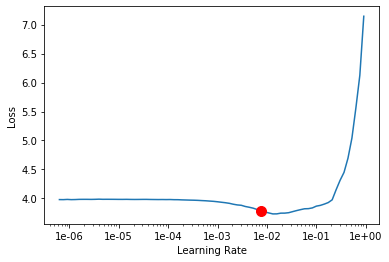

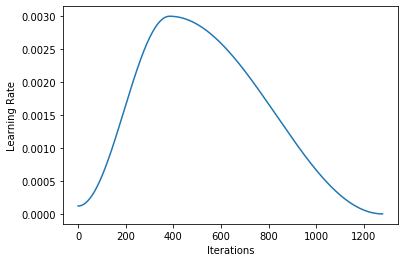

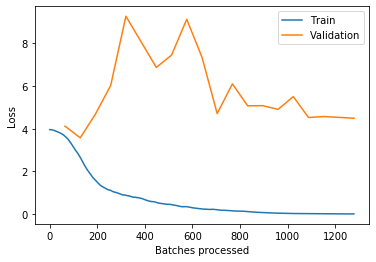

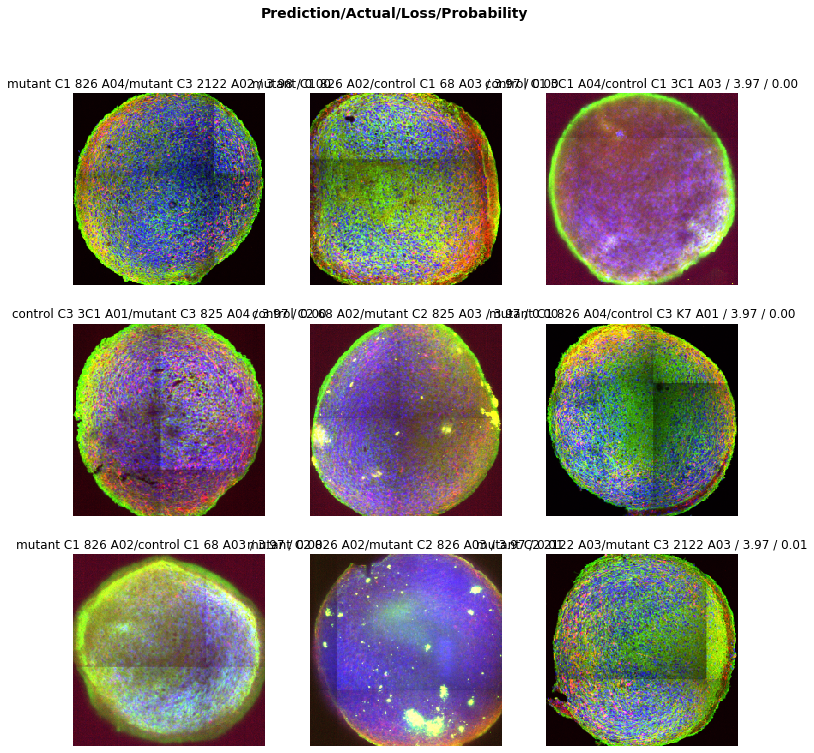

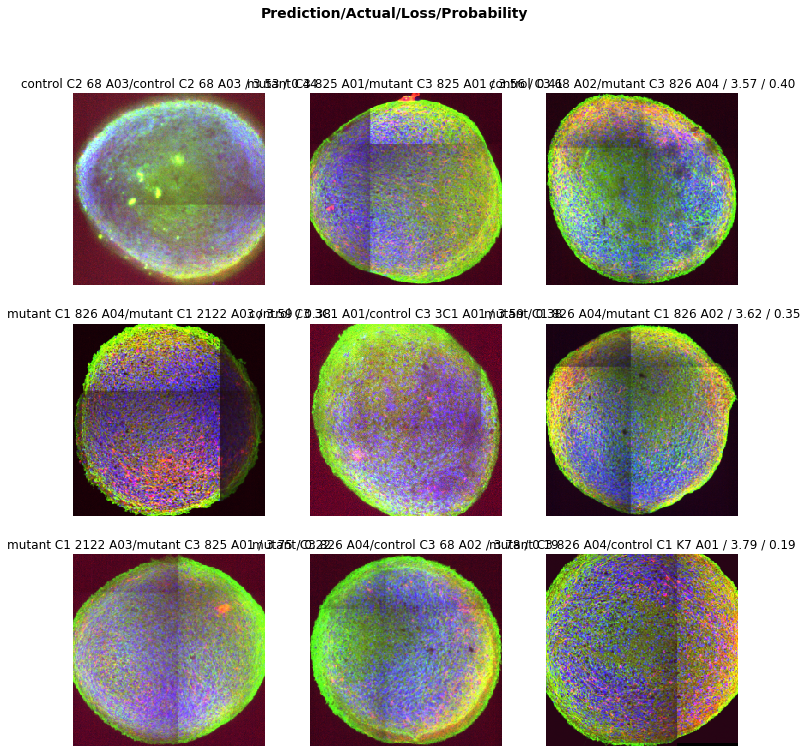

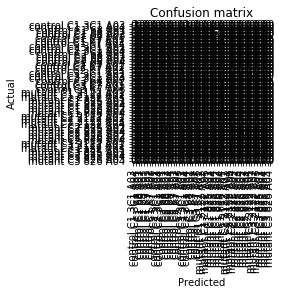

In [12]:
print('Unfreeze...')
#learn.unfreeze()
print('LR find...')
learn.lr_find()
fig = learn.recorder.plot(suggestion=True,return_fig=True)
fig.savefig(outputDir + runPrefix + 'lrfind_unfrozen.png')
suggested_lr = learn.recorder.min_grad_lr
print('Continue trainig...')
# train using fit one cycle policy, autosave the model with the best validation accuracy, overwirte it when there is a
# n improvement (i.e. keep the single best)
myCbs=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name = runPrefix + 'BestModel')]
learn.fit_one_cycle(20,callbacks=myCbs)

fig = learn.recorder.plot_lr(return_fig=True) #plot plots LR vs loss
fig.savefig(outputDir + runPrefix + 'train_lr_unfrozen.png')
fig = learn.recorder.plot_losses(return_fig=True)
fig.savefig(outputDir + runPrefix + 'train_losses_unfrozen.png')
## vs learn.fit
#learn.fit_one_cycle(20,max_lr = slice(1e-6,3e-4))
learn.save(outputDir + runPrefix + "LastModel" )
learn.export(outputDir + runPrefix + "LastModelExport")
print('ClassificationInterpretation with TTA')
interp = ClassificationInterpretation.from_learner(learn, tta=True)
print(str(interp.confusion_matrix()))
pFlop9 = interp.plot_top_losses(9,return_fig=True)
#pFlop9Heatmap = interp.plot_top_losses(9,heatmap=True,return_fig=True)
pTop9 = interp.plot_top_losses(9,return_fig=True, largest=False)
#pTop9Heatmap = interp.plot_top_losses(9,heatmap=True,return_fig=True, largest=False)
pConfMat = interp.plot_confusion_matrix(return_fig=True)
pTop9.savefig(outputDir + runPrefix + 'top9.png')
#pTop9Heatmap.savefig(path + 'top9heatmap.png')
pFlop9.savefig(outputDir + runPrefix + 'flop9.png')
#pFlop9Heatmap.savefig(path + 'flop9heatmap.png')
pConfMat.savefig(outputDir + runPrefix + 'confmat.png')
preds,y = learn.TTA() # TTA should apply specified crop transforms (but not crop_pad!) so it should be okay
acc = accuracy(preds, y)
print('The validation accuracy is {} %.'.format(acc * 100))

## Test set

In [21]:
test_multilabel = get_labels(test_files)

In [22]:
test_dict = {'image_name': test_files, 'tags': test_multilabel}
test_df = pd.DataFrame(test_dict)
test_df

,image_name,tags
0,C2_K7_Un_1_15_S_A01_c_4_p_6_RGB_1.png,control C2 K7 A01
1,C3_68_100_1_66_S_A03_c_4_p_6_RGB_1.png,control C3 68 A03
2,C2_3C1_10_1_37_S_A03_c_4_p_19_RGB_1.png,control C2 3C1 A03
3,C1_68_Un_1_68_S_A04_c_4_p_10_RGB_1.png,control C1 68 A04
4,C3_K7_100_1_27_S_A02_c_4_p_6_RGB_1.png,control C3 K7 A02
5,C2_K7_10_2_25_S_A02_c_4_p_19_RGB_1.png,control C2 K7 A02
6,C3_68_Un_1_3_S_A01_c_4_p_8_RGB_1.png,control C3 68 A01
7,C2_K7_100_1_18_S_A02_c_4_p_12_RGB_1.png,control C2 K7 A02
8,C3_K7_Un_2_4_S_A01_c_4_p_7_RGB_1.png,control C3 K7 A01
9,C3_68_100_2_54_S_A03_c_4_p_1_RGB_1.png,control C3 68 A03


In [23]:
to_keep = train_files + test_files

test = dframe.copy()
test = test[test['image_name'].isin(to_keep)]
test['is_valid'] = np.where(test['image_name'].isin(test_files), True, False)
test.to_csv(os.path.join('/work/projects/hcs_ai/abottemanne/thesis/images/RGB_1_5262020/AllImages/data','fold1mltest.csv'), index=False)
test['is_valid'].value_counts()

False    4149
True       26
Name: is_valid, dtype: int64

In [24]:
tfms = get_transforms(flip_vert = True, max_lighting = 0.1, max_zoom = 1.05, max_warp = 0)
test_src = (ImageList.from_csv(PATH,'fold1mltest.csv').split_from_df(col='is_valid').label_from_df(cols='tags'))
test_data = (test_src.transform(tfms, size=model_type[1]).databunch().normalize())

/home/users/abottemanne/.local/lib/python3.7/site-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
control C3 68 A01, control C1 68 A04, control C3 68 A03, mutant C1 826 A01, mutant C3 826 A02
  if getattr(ds, 'warn', False): warn(ds.warn)


In [25]:
test_data

ImageDataBunch;

Train: LabelList (4149 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
mutant C2 825 A03,mutant C2 2122 A03,mutant C2 825 A03,control C2 3C1 A04,mutant C1 825 A04
Path: /work/projects/hcs_ai/abottemanne/thesis/images/RGB_1_5262020/AllImages/data;

Valid: LabelList (20 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
control C2 K7 A01,control C2 3C1 A03,mutant C3 2122 A02,mutant C1 826 A03,mutant C3 826 A04
Path: /work/projects/hcs_ai/abottemanne/thesis/images/RGB_1_5262020/AllImages/data;

Test: None

In [26]:
os.listdir(outputDir)
runPrefix + 'BestModel.pth'

'alexEfficientNetB0FullImgNetOneCycle20_4MULTILABELSBestModel.pth'

In [27]:
model = EfficientNet.from_pretrained(model_type[0], num_classes=test_data.c)
model_name = runPrefix + 'BestModel.pth'
best_model_saved = torch.load(os.path.join(outputDir, model_name))
model.load_state_dict(best_model_saved['model'])

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

In [28]:
learn = Learner(test_data, model, metrics = [accuracy])
preds, y = learn.get_preds(DatasetType.Valid) 
y_preds = torch.argmax(preds, dim=1)
print("Accuracy: ", accuracy_score(y_preds, y))

Accuracy:  0.1
